In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t, y_t

In [3]:
class Block(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.proj = nnx.Conv(dim, dim_out, (3, 3), padding = 'CIRCULAR', rngs = rngs)
        self.norm = nnx.BatchNorm(dim_out, rngs = rngs)

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return nnx.silu(x)

class ResnetBlock(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.block1 = Block(dim, dim_out, rngs = rngs)
        self.block2 = Block(dim_out, dim_out, rngs = rngs)
        self.block3 = Block(dim_out, dim_out, rngs = rngs)
        self.res_conv = nnx.Conv(dim, dim_out, (1, 1), rngs = rngs)

    def __call__(self, x):
        h = self.block1(x)
        h = self.block2(h)
        h = self.block3(h)
        return h + self.res_conv(x)

class ClimateNO(nnx.Module):
    def __init__(self, lag, rngs = nnx.Rngs):
        self.enc = nnx.Conv(lag, 30, (1, 1), rngs = rngs)
        self.res1 = ResnetBlock(30, 32, rngs = rngs)
        self.res2 = ResnetBlock(32, 16, rngs = rngs)
        self.res3 = ResnetBlock(16, 1, rngs = rngs)
        self.dec = nnx.Conv(1, 1, (1, 1), rngs = rngs)

    def __call__(self, x):
        m = jnp.mean(x, axis = 3)[:,:,:,None]
        h = self.enc(x - m)
        h = self.res1(h)
        h = self.res2(h)
        h = self.res3(h)
        h = self.dec(h)
        return m + h

In [4]:
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)  # call methods directly
    return ((y_pred - y) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates

  return loss

train_step = nnx.jit(train_step)

In [5]:
dtrain = np.load('./data/era5_train_small.npy', mmap_mode='r+')

In [6]:
lag = 24
horizon = 4
epochs = 5
batch = 64
groups = 10
niter = int(5200/batch)
trace = []

model = ClimateNO(lag, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for b in trange(epochs):

    for g in trange(groups, leave = False):
        xtrain, ytrain = split_data(dtrain[(g*5200):((g+1)*5200)], lag, horizon)
        rng, perm_rng = random.split(rng, 2)
        xtrain = random.permutation(perm_rng, xtrain)
        ytrain = random.permutation(perm_rng, ytrain)
    
        for i in trange(niter, leave = False):
            xt = xtrain[(i*batch):((i+1)*batch)]
            yt = ytrain[(i*batch):((i+1)*batch)]
    
            loss = train_step(model, optim, xt, yt)
            trace.append(loss)
    print(f'loss: {loss}', end='\r')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 3.4728071689605713

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.988978624343872

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.9423558712005615

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.833552360534668

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.9260263442993164

In [7]:
import os
import orbax.checkpoint as ocp

# extract state
_, state = nnx.split(model)

# save
checkpointer = ocp.StandardCheckpointer()
checkpointer.save(os.getcwd() + '/models/' + 'era5_small_state', state)

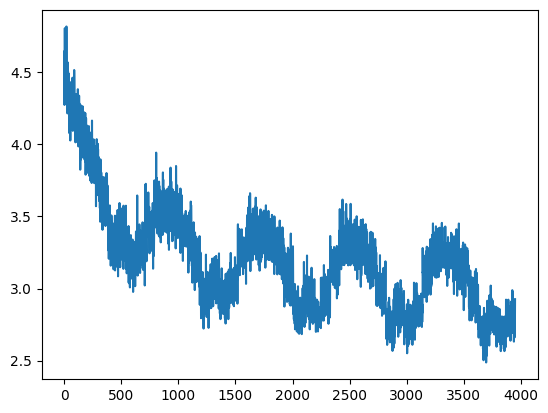

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/tharris/climate/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/tharris/climate/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/tharris/climate/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/tharris/climate/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1972, in _run_once
    handle = self._ready.popleft()
             ^^^^^^^^^^^^^^^^^^^^^
IndexError: pop from an empty deque


In [8]:
plt.plot(trace[100:])